# Capstone Project | Fraud Detection

## Problem
In this project, we explore a dataset containing mobile financial transaction details, including transaction amount, transaction type, balance details and more. Our objective is to develop a predictive model capable of accurately identifying fraudulent transactions. Given the significant financial and reputational risks associated with undetected fraud, our primary focus is on ensuring that the model correctly identifies all potential fraudulent activities, making recall for the fraudulent class a crucial metric.

## Objectives:


## Import Necessary Libraries

In [977]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [978]:
# Configure Seaborn plot styles: Set background color
sns.set(rc={'axes.facecolor': '#e2f2ff'})
sns.set_palette(['#0099ff', '#55d3ff'])

## Load the Dataset

In [979]:
# Read the Dataset and display it
fddf = pd.read_csv('Fraud_Analysis_Dataset.csv')
fddf

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1
4,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...
11137,7,DEBIT,6393.71,C1331144930,433084.38,426690.68,C684896216,478421.00,210535.25,0
11138,7,CASH_OUT,298799.54,C932023579,426690.68,127891.14,C1761353343,704355.36,5270364.19,0
11139,7,CASH_OUT,423159.63,C61395726,127891.14,0.00,C1298316171,610479.00,749621.53,0
11140,7,PAYMENT,1094.03,C1224570697,13918.00,12823.97,M983553548,0.00,0.00,0


### Data Description
| __Variable__      | __Description__                                                                                 |
|:------------------|:------------------------------------------------------------------------------------------------|
| __step__          | Maps a unit of time in the real world. In this case, 1 step is 1 hour of time.                  |
| __type__          | Transaction type: <br> - CASH-IN:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Depositing cash<br> - CASH-OUT:&nbsp;&nbsp;&nbsp;Withdrawing cash <br> - DEBIT:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Decrease in account balance due to withdrawal or expense. <br> - PAYMENT:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Transfer of money in exchange for goods, services, or debt settlement. <br> - TRANSFER:&nbsp;&nbsp;&nbsp;&nbsp;Moving money between accounts. |
| __amount__        | Amount of the transaction in local currency (Rs.).                                                    |
| __nameOrig__      | Customer who started the transaction.                                                           |
| __oldbalanceOrg__ | Initial balance of the customer before the transaction.                                         |
| __newbalanceOrig__| New balance of the customer after the transaction.                                              |
| __nameDest__      | Customer who is the recipient of the transaction.                                               |
| __oldbalanceDest__| Initial balance of the recipient before the transaction. <br> Note: No information for customers that start with 'M' (Merchants). |
| __newbalanceDest__| New balance of the recipient after the transaction. <br> Note: No information for customers that start with 'M' (Merchants). |
| __isFraud__       | Fraud status: <br> 0 - Not Fraud <br> 1 - Fraud |

## Dataset Overview

### Checking Data Types

In [980]:
fddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB


In [981]:
# Checking the null values
fddf.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [982]:
#Checking the dupliacted values if any
fddf.duplicated().sum()

0

#### Inferences:
* __Number of Entries:__ The dataset consists of ___11142 entries___.
* __Columns:__ There are ___10 columns___ in the dataset related to a Transaction details.
* __Data Types:__
    * ___5 columns___ are of the ___float64___ data type.
    * ___2 columns___ are of the ___int64___ data type.
    * ___3 columns___ are of the ___object___ data type.
* __Missing Values:__ There are no missing values in the dataset as each column has ___11142 non-null entries___.
* __Duplicate Values:__ There are no duplicate values.

#### Note:
* Based on the data types and feature explaination, the ___isFraud___ column is a ___categorical___ data but is converted to ___binary___. So we will convert it to ___object___ data type for proper analysis.

In [983]:
# Converting isFraud column to object data type
new_fddf = fddf.copy()
new_fddf[['isFraud']] = new_fddf[['isFraud']].astype('object')

new_fddf.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud            object
dtype: object

### Summary Statistics

#### Numerical Data

In [984]:
new_fddf.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,11142.00,11142.00,11142.00,11142.00,11142.00,11142.00
mean,8.72,213191.49,924117.26,824957.65,888354.08,1103211.48
std,16.07,760065.01,2143004.31,2089894.17,2601375.85,2982447.12
min,1.00,2.39,0.00,0.00,0.00,0.00
25%,2.00,4946.62,427.00,0.00,0.00,0.00
50%,6.00,16761.26,28169.50,4420.60,0.00,0.00
75%,7.00,154336.58,304085.48,111412.64,271155.47,318637.36
max,95.00,10000000.00,19900000.00,13000000.00,33000000.00,34600000.00


##### Numerical Features:
* __step__: The time starts from 1st hour and ends at 95th hour. Also the 50 percentile is 6 and 75 percentile is 7 showing that between there are lot of enteries between these times.
* __amount__: The average transaction amount is of ___Rs 213,191.49___, with the lowest being ___Rs 2.39___ and the highest ___Rs 1 Cr.___
* __oldbalanceOrg__: The average balance of the origin account before the transaction is of ___Rs 924,117.26___, with the minimum of ___Rs 0___ and the maximum of ___Rs 1.99 Cr.___
* __newbalanceOrig__: The average balance of the origin account after the transaction is of ___Rs 824957.65___, with the minimum of ___Rs 0___ and the maximum of ___Rs 1.3 Cr.___
* __oldbalanceDest__: The average balance of the destinantion account before the transaction is of ___Rs 888354.08___, with the minimum of ___Rs 0___ and the maximum of ___Rs 3.3 Cr.___
* __newbalanceDest__: The average balance of the destinantion account after the transaction is of ___Rs 1103211.48___, with the minimum of ___Rs 0___ and the maximum of ___Rs 3.46 Cr.___

##### Inference:
* The ___standard deviations___ of all the numerical columns are ___very high___, indicating there are many ___outliers___.

#### Categorical Data

In [985]:
new_fddf.describe(include='object')

,type,nameOrig,nameDest,isFraud
count,11142,11142,11142,11142
unique,5,11142,7508,2
top,PAYMENT,C1305486145,C985934102,0
freq,5510,1,62,10000


##### Numerical Features:
* __type__: It has ___5___ unique values, with ___PAYMENT___ type being the most common one.
* __nameOrig__: It has ___11142___ unique values, meaning every transaction is made by a different person.
* __nameDest__: It has ___7508___ unique values, with ___C985934102___ customer being a common recipient of transactions involved in 62 transactions. 
* __isFraud__: It has ___2___ unique values, with ___0___ being the most frequent. It means most of the transactions are ___Not Fraud___.

## EDA | Exploratory Data Anlaysis

### Univariate Analysis

#### Numerical Variables

In [986]:
# Defining a variable for numerical columns
numerical_data = new_fddf.select_dtypes(exclude='O')
numerical_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,181.0,181.0,0.0,0.0,0.0
1,1,181.0,181.0,0.0,21182.0,0.0
2,1,2806.0,2806.0,0.0,0.0,0.0
3,1,2806.0,2806.0,0.0,26202.0,0.0
4,1,20128.0,20128.0,0.0,0.0,0.0


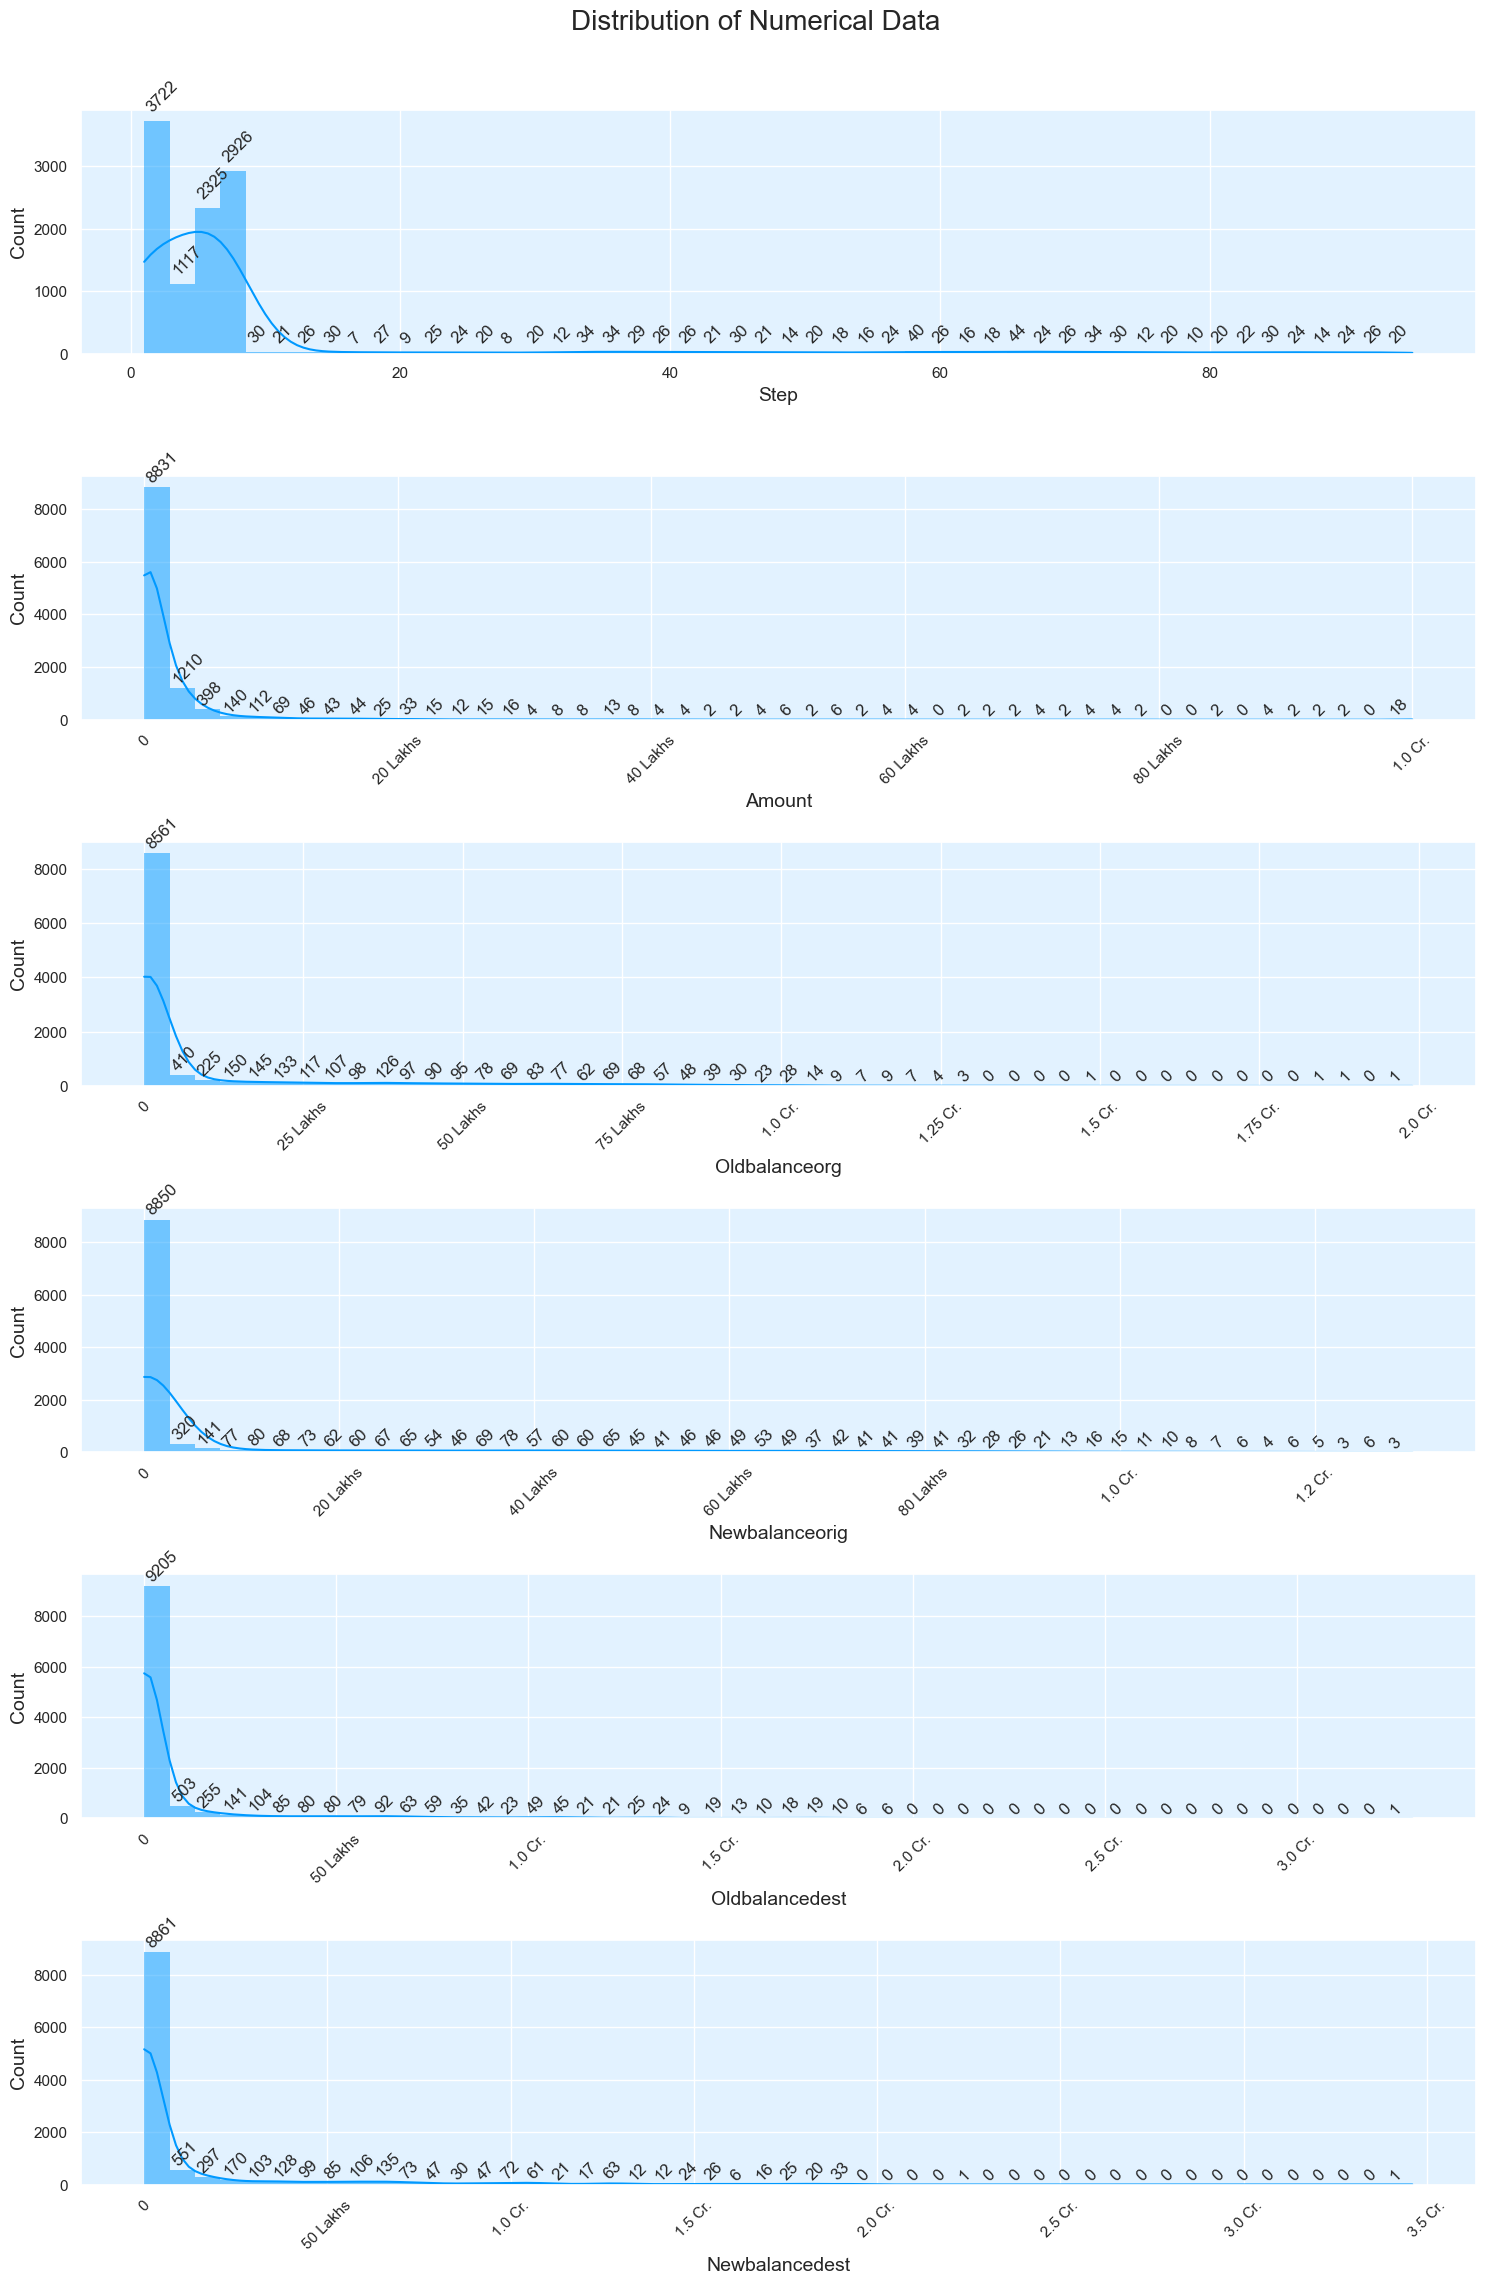

In [987]:
# Setting up the subplot
fig, ax = plt.subplots(nrows=6,figsize=(18, 25))
x = 0

# Looping to plot histogram for each columns
for cols in numerical_data:
    
    count_plot = sns.histplot(numerical_data[cols], bins=50, kde=True, ax=ax[x], edgecolor='none')
    count_plot.set_xlabel(cols.capitalize(),fontsize=14)
    count_plot.set_ylabel('Count',fontsize=14)
    if cols != 'step':
        count_plot.set_xticklabels([str(i/10000000)+' Cr.' if abs(i) >= 10000000
                             else (0 if int(i) == 0 else str(int(i/100000))+' Lakhs') for i in count_plot.get_xticks()],
                            rotation=45)
    count_plot.grid(color='white')
    
    for i, patch in enumerate(count_plot.patches):
        count_plot.annotate(text = patch.get_height(),
                         xy = (patch.get_x(), patch.get_height() + max(patch.get_height()*0.02, 150)),
                         rotation=45)
        
    x += 1

plt.suptitle('Distribution of Numerical Data',fontsize=20)
plt.subplots_adjust(hspace=0.5, top=0.94)
plt.show()

##### Inferences:
* All the numerical columns are __highly left-skewed__. This confirms the presence of __outliers__.
* In the Step variable, we can see that most of the values are __below 20__, meaning most of the transactions are done within the 20 hour stamp.
* Most of the Data values are relatively small as we have already seen in the summary statistics that the lowest value is 0 in most variables.

#### Categorical Variables

In [988]:
# Defining a variable for categorical columns
category_data = new_fddf.select_dtypes(include='O')
category_data.head()

,type,nameOrig,nameDest,isFraud
0,TRANSFER,C1305486145,C553264065,1
1,CASH_OUT,C840083671,C38997010,1
2,TRANSFER,C1420196421,C972765878,1
3,CASH_OUT,C2101527076,C1007251739,1
4,TRANSFER,C137533655,C1848415041,1


We will be plotting the graphs only for __type__ and __isFraud__ variable as the name variables have very high unique values.
<br>We will drop the name variables after the EDA.

In [989]:
# Defining a variable for categorical columns
category_data = new_fddf[['type','isFraud']]
category_data.head()

,type,isFraud
0,TRANSFER,1
1,CASH_OUT,1
2,TRANSFER,1
3,CASH_OUT,1
4,TRANSFER,1


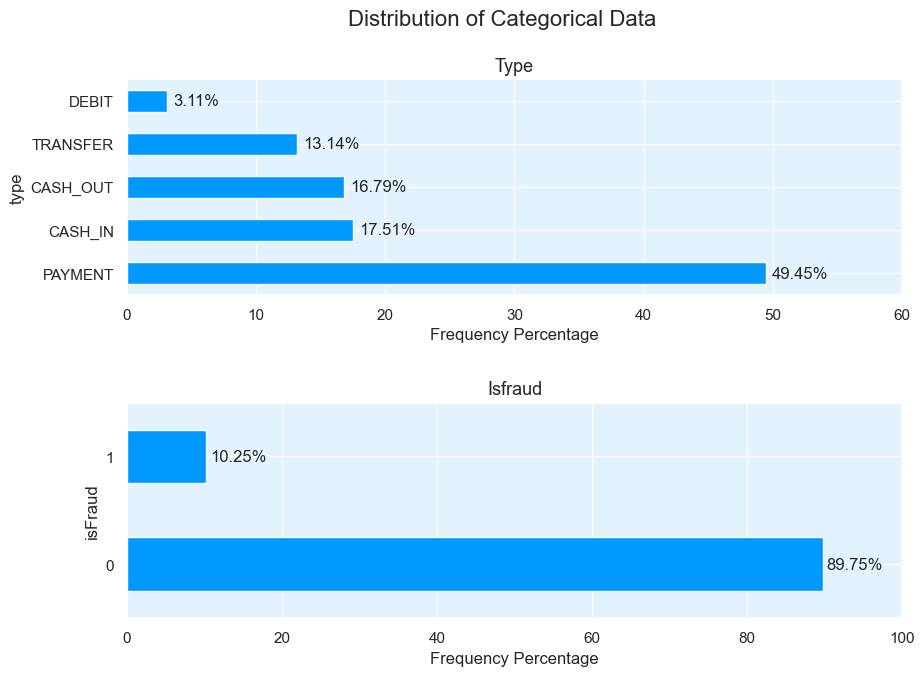

In [990]:
# Setting up the subplot
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10, 7))
x = 0

# Looping to plot histogram for each columns
for cols in category_data:

    value_count = category_data[cols].value_counts(normalize=True)
    bar_plot = value_count.plot(kind='barh',ax=ax[x],edgecolor='white')

    for index, value in enumerate(value_count):
        bar_plot.text(value+0.005,index,str(round(value*100,2)) + '%',va='center')

    if cols == 'type':
        bar_plot.set_xlim([0,0.60])
    else:
         bar_plot.set_xlim([0,1])

    bar_plot.set_xticklabels([int(round(i*100,0)) for i in bar_plot.get_xticks()])
    bar_plot.set_xlabel('Frequency Percentage',fontsize=12)
    bar_plot.set_title(cols.capitalize(), fontsize=13)

    bar_plot.grid(color='white')
        
    x += 1
        
plt.suptitle('Distribution of Categorical Data',fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.show()

##### Inferences:
* __Type__: The ___PAYMENT___ type is the most common transaction type making up ___49.45%___ of all the transactions. 
* __isFraud__: The majority of the transactions are actually ___not fraud___, with ___89.75%___ of the transactions being ___not fraud___ and remaining ___10.25%___ being ___Fraud___.

### Bivariate Analysis

#### Categorical Features

In [991]:
# Defining Proportion table for types
type_prop = pd.crosstab(index=category_data['type'], columns=category_data['isFraud'], normalize='index')
round(type_prop,2)

isFraud,0,1
type,,
CASH_IN,1.00,0.00
CASH_OUT,0.69,0.31
DEBIT,1.00,0.00
PAYMENT,1.00,0.00
TRANSFER,0.61,0.39


In [992]:
# Defining count pivot table for types
type_pivot = pd.pivot_table(fddf,index='type', columns='isFraud', values='step', aggfunc='count').fillna(0)
type_pivot

isFraud,0,1
type,,
CASH_IN,1951.0,0.0
CASH_OUT,1293.0,578.0
DEBIT,346.0,0.0
PAYMENT,5510.0,0.0
TRANSFER,900.0,564.0


<Figure size 500x500 with 0 Axes>

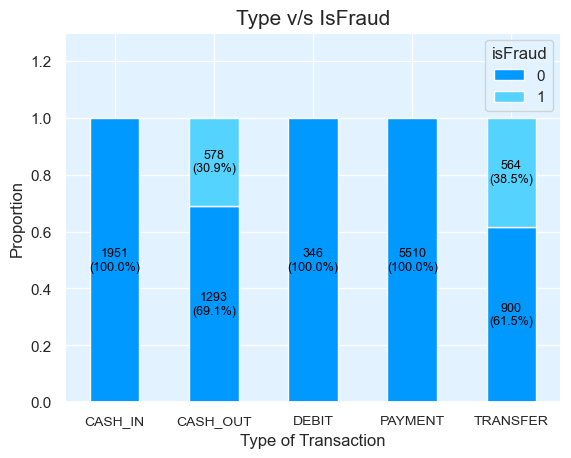

In [993]:
# Plotting the Stacked Bar Chart
plt.figure(figsize=(5,5))
graph = type_prop.plot(kind='bar', stacked=True, edgecolor='white',zorder=2)

for j in type_pivot:
    for ind, (prop, val) in enumerate(zip(type_prop[j],type_pivot[j])):
        if int(val) == 0:
            continue
        graph.text(ind,prop/2 if j == 0 else prop/2+(1-prop),f'{int(val)}\n({round(prop*100,1)}%)', color='black', fontsize=9, va='center',ha='center')
        
graph.set_ylim([0,1.3])
plt.xlabel('Type of Transaction', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
graph.set_xticklabels(graph.get_xticklabels(), fontsize=10, rotation=0)

plt.title('Type v/s IsFraud',fontsize=15)
plt.grid(color='white')

##### Inferences:
* __CASH_OUT__: ___30.9%___ of all the cash withdrawls are Fraud, remaining ___69.1%___ being normal/safe transactions.
* __TRANSFER__: ___38.5%___ of all the Transfers are Fraud, remaining ___61.5%___ being normal Transfers.

##### Summary:
* Only __CASH_OUT__ and __TRANSFER__ type of transactions show signs of fraudulent activity.
* The Number of Fraud Transactions are almost equally distributed between these both Types.

### Multivariate Analysis

We will be plotting Correlation Heatmap for the Multivariate Analysis.<br>To capture the relation of categorical data, we will be using One-Hot Encoding on it.

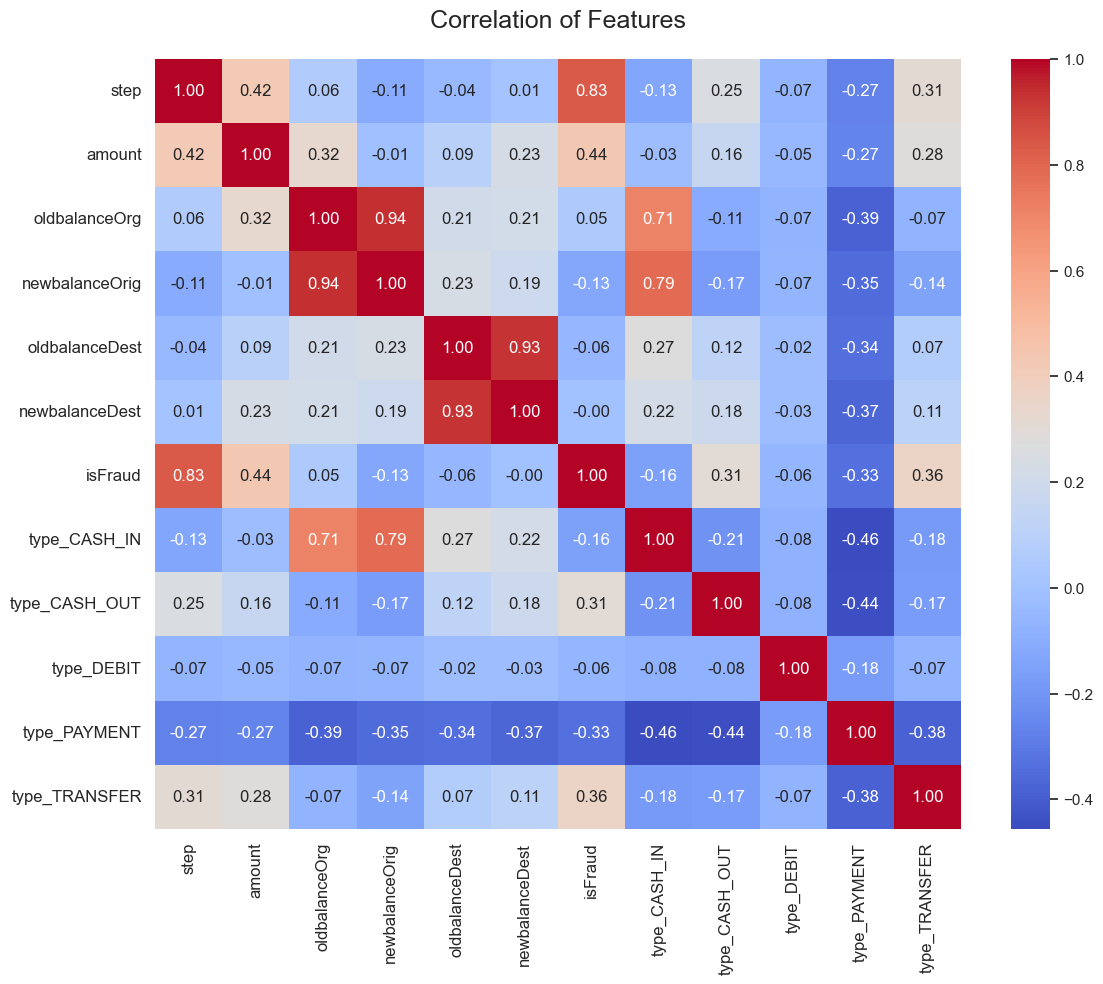

In [994]:
fddf_ohe = pd.get_dummies(fddf, columns=['type'],dtype='uint8')
fddf_ohe.drop(['nameOrig', 'nameDest'],axis=1,inplace=True)

plt.figure(figsize=(13,10))
corr_plot = sns.heatmap(fddf_ohe.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation of Features',y=1.03, fontsize=18)
corr_plot.tick_params(labelsize=12)

##### Inferences:
* The __step__ variable has ___high positive correlation___ with the Target variable, meaning more Fraud activities happen during late hours.
* Features like __amount__, __Type - CASH_OUT__ and __Type - TRANSFER__ are ___moderately___ & ___positively correlated___ to Target variable.
* The __PAYMENT Type___ of Transaction has ___moderete negative correlation___ with the Target variable, meaning payment transactions are more likely to be safe.
* Other remaining features, like __Old & New balances of payers and receipients__ and __CASH_IN & DEBIT Types__, are ___less correlated___ to the Target variable. They do not affect transactions much for being fraud or not.

## Data Preprocessing

In [995]:
nfddf = fddf.copy()

### Feature Engineering

#### Feature Creation

##### Difference in balance for both Orig. and Dest. accounts
We can create Balance Diff. features for both Orig. and Dest. accounts. It can show whether the account was deducted or there was an addition.

In [996]:
# Creating balance difference features for Orig. account
nfddf['bal_diff_orig'] = nfddf['newbalanceOrig'] - nfddf['oldbalanceOrg']

# Creating balance difference features for Dest. account
nfddf['bal_diff_dest'] = nfddf['newbalanceDest'] - nfddf['oldbalanceDest']

nfddf.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,bal_diff_orig,bal_diff_dest
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,-181.0,0.0
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,-181.0,-21182.0
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,-2806.0,0.0
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,-2806.0,-26202.0
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,-20128.0,0.0


In [997]:
nfddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
 10  bal_diff_orig   11142 non-null  float64
 11  bal_diff_dest   11142 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 1.0+ MB


##### Balance Difference / Amount
We can create feature for relation between amount and  balance differences. It can show the intensity of the the amount with the balance changes.

In [998]:
# Creating balance difference of origin / account
nfddf['bal_diff_orig/amount'] = nfddf['bal_diff_orig'] / nfddf['amount']

# Creating balance difference of destination / account
nfddf['bal_diff_dest/amount'] = nfddf['bal_diff_dest'] / nfddf['amount']

nfddf.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,bal_diff_orig,bal_diff_dest,bal_diff_orig/amount,bal_diff_dest/amount
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,-181.0,0.0,-1.0,0.000000
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,-181.0,-21182.0,-1.0,-117.027624
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,-2806.0,0.0,-1.0,0.000000
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,-2806.0,-26202.0,-1.0,-9.337847
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,-20128.0,0.0,-1.0,0.000000


In [999]:
nfddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step                  11142 non-null  int64  
 1   type                  11142 non-null  object 
 2   amount                11142 non-null  float64
 3   nameOrig              11142 non-null  object 
 4   oldbalanceOrg         11142 non-null  float64
 5   newbalanceOrig        11142 non-null  float64
 6   nameDest              11142 non-null  object 
 7   oldbalanceDest        11142 non-null  float64
 8   newbalanceDest        11142 non-null  float64
 9   isFraud               11142 non-null  int64  
 10  bal_diff_orig         11142 non-null  float64
 11  bal_diff_dest         11142 non-null  float64
 12  bal_diff_orig/amount  11142 non-null  float64
 13  bal_diff_dest/amount  11142 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 1.2+ MB


#### Feature Selection

The nameOrig and nameDest features are needed to be removed becuase they ar just unique ids of customers.<br>
I removed the step column also.

In [1000]:
# Deleting the unwanted features
nfddf = nfddf.drop(['step','nameOrig','nameDest'],axis=1)
nfddf.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,bal_diff_orig,bal_diff_dest,bal_diff_orig/amount,bal_diff_dest/amount
0,TRANSFER,181.0,181.0,0.0,0.0,0.0,1,-181.0,0.0,-1.0,0.000000
1,CASH_OUT,181.0,181.0,0.0,21182.0,0.0,1,-181.0,-21182.0,-1.0,-117.027624
2,TRANSFER,2806.0,2806.0,0.0,0.0,0.0,1,-2806.0,0.0,-1.0,0.000000
3,CASH_OUT,2806.0,2806.0,0.0,26202.0,0.0,1,-2806.0,-26202.0,-1.0,-9.337847
4,TRANSFER,20128.0,20128.0,0.0,0.0,0.0,1,-20128.0,0.0,-1.0,0.000000


### Categorical Features Encoding

In [1001]:
# Applying One-Hot Encoding to Type column
nfddf = pd.get_dummies(nfddf,columns=['type'], drop_first=True, dtype='uint8')
nfddf.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,bal_diff_orig,bal_diff_dest,bal_diff_orig/amount,bal_diff_dest/amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,181.0,181.0,0.0,0.0,0.0,1,-181.0,0.0,-1.0,0.000000,0,0,0,1
1,181.0,181.0,0.0,21182.0,0.0,1,-181.0,-21182.0,-1.0,-117.027624,1,0,0,0
2,2806.0,2806.0,0.0,0.0,0.0,1,-2806.0,0.0,-1.0,0.000000,0,0,0,1
3,2806.0,2806.0,0.0,26202.0,0.0,1,-2806.0,-26202.0,-1.0,-9.337847,1,0,0,0
4,20128.0,20128.0,0.0,0.0,0.0,1,-20128.0,0.0,-1.0,0.000000,0,0,0,1


### Train-Test Split

In [753]:
# Defining the features variable and target variable
X = nfddf.drop(['isFraud'],axis=1)
y = nfddf['isFraud']

In [754]:
# Splitting the Data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [755]:
print(X_train.shape, y_train.shape)
X_test.shape, y_test.shape

(8356, 13) (8356,)


((2786, 13), (2786,))

In [756]:
y_train.value_counts(), y_test.value_counts()

(isFraud
 0    7498
 1     858
 Name: count, dtype: int64,
 isFraud
 0    2502
 1     284
 Name: count, dtype: int64)

### Feature Scaling

Because our dataset have extreme outliers, we will be using __Robust Scaler__ to scale the dataset.

In [757]:
# Scaling the dataset
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Building and Evaluation

### Logistic Regression

#### Base Model

In [758]:
# Defining the base model
model_lr = LogisticRegression(random_state=42)

#### Hyper-Parameter Tuning

To minimize the losses of fraudlent transactions, we need the model to have high recall. A high recall ensures that most of the true positives,i.e., actual fraud cases, are correctly identified, even if there are some false positives (non fraud transactions detected as fraud).

In [759]:
# Defining the params for tuning
param_lr = {'penalty' : ['l1', 'l2'],
            'C' : [0.001, 0.01, 0.1, 1, 10],
            'solver' : ['liblinear','lbfgs']}

In [760]:
# Performing Grid Search with cv=5 and fitting the dataset
grid_lr = GridSearchCV(model_lr, param_lr, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_lr.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='recall', verbose=1)

In [761]:
# Defining the best model variable
best_model_lr = grid_lr.best_estimator_
best_model_lr

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

Best parameters are:<br>
C = 10,<br>
penalty = l1,<br>
solver = liblinear,<br>random_state=42

#### Model Evaluation

In [762]:
# Predicting the training set and printing the classification report
train_predict_lr = best_model_lr.predict(X_train_scaled)
print(metrics.classification_report(y_train,train_predict_lr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7498
           1       0.88      0.97      0.93       858

    accuracy                           0.98      8356
   macro avg       0.94      0.98      0.96      8356
weighted avg       0.99      0.98      0.98      8356



In [763]:
# Predicting the test set and printing the classification report
predict_lr = best_model_lr.predict(X_test_scaled)
print(metrics.classification_report(y_test,predict_lr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2502
           1       0.90      0.97      0.93       284

    accuracy                           0.99      2786
   macro avg       0.95      0.98      0.96      2786
weighted avg       0.99      0.99      0.99      2786



In [764]:
# Checking auc scores
print('Train -', metrics.roc_auc_score(y_train,train_predict_lr))
print('Test -', metrics.roc_auc_score(y_test,predict_lr))

Train - 0.9787453810526631
Test - 0.9797204489929184


In [765]:
train_loss = metrics.log_loss(y_train,train_predict_lr)
test_loss = metrics.log_loss(y_test,predict_lr)
train_loss, test_loss

(0.573696254278672, 0.5045593977658182)

In [766]:
def plot_cm(y_train,pred_train,y_test,pred_test):
    '''
    This function plots the confusion matrix heatmaps for both train
    and test data predictions to compare and check the performance
    of the model.
    '''
    fig, ax = plt.subplots(1,2,figsize=(10,4))

    # Plotting Confusion matrix for train set
    cm_train = metrics.confusion_matrix(y_train,pred_train)
    sns.heatmap(cm_train, annot=True, ax=ax[0], fmt='d', cmap='Blues', cbar=False)
    ax[0].set_title('Train',fontsize=14)
    ax[0].set_xlabel('Predicted Value')
    ax[0].set_ylabel('True Value')

    # Plotting Confusion matrix for test set
    cm_test = metrics.confusion_matrix(y_test,pred_test)
    sns.heatmap(cm_test, annot=True, ax=ax[1], fmt='d', cmap='Blues', cbar=False)
    ax[1].set_title('Test',fontsize=14)
    ax[1].set_xlabel('Predicted Value')
    ax[1].set_ylabel('True Value')

    plt.suptitle('Confusion Matrix',fontsize=18)
    plt.subplots_adjust(wspace=0.6,top=0.8)

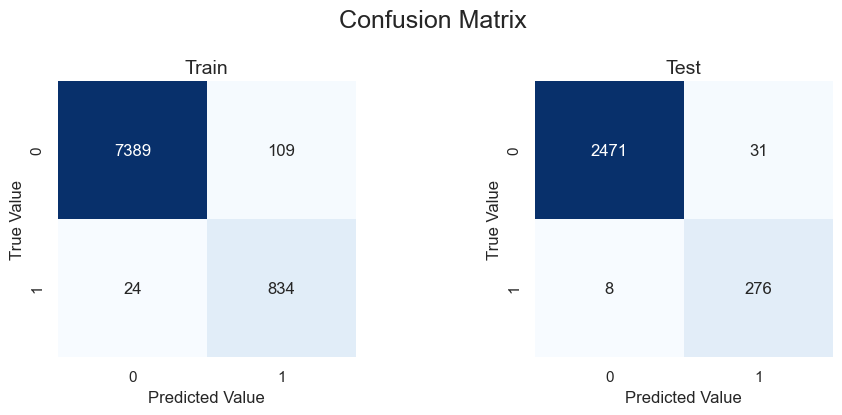

In [767]:
# Plotting the confusion matrix for comparison
plot_cm(y_train,train_predict_lr,y_test,predict_lr)

##### Inference:
All of the metric values of the training and test datasets are closely aligned.<br>
The AUC scores are close to 1.<br>
Also, the train and test losses are low and close to each other.<br>
This means the model is not overfitting and has performed well.

To compare all the models in the future, lets create a function to make a dataframe of the metrics.

In [768]:
def metrics_df(model, X_test, y_test, model_name):
    '''
    Calculates the performace metrics of the trained model over the test data
    and creates a dataframe out of it.
    '''
    # Making predictions
    y_pred = model.predict(X_test)

    # Calculating the metric scores for class 1(is Fraud)
    precision_1 = metrics.precision_score(y_test,y_pred)
    recall_1 = metrics.recall_score(y_test,y_pred)
    f1_1 = metrics.f1_score(y_test,y_pred)
    accuracy = metrics.accuracy_score(y_test,y_pred)

    # Calculating the metric scores for class 0(not Fraud)
    precision_0 = metrics.precision_score(y_test,y_pred,pos_label=0)
    recall_0 = metrics.recall_score(y_test,y_pred,pos_label=0)
    f1_0 = metrics.f1_score(y_test,y_pred,pos_label=0)
    
    # Making the DataFrame
    df = pd.DataFrame({'Precision_0' : precision_0,
                       'Precision_1' : precision_1,
                       'Recall_0' : recall_0,
                       'Recall_1' : recall_1,
                       'F1-Score_0' : f1_0,
                       'F1-Score_1' : f1_1,
                       'Accuracy' : accuracy,}, index=[model_name]).round(2)
    
    return df

In [769]:
# Defining the metrics data frame for logistic regression
lr_df = metrics_df(best_model_lr,X_test_scaled,y_test,'Logistic Regression')
lr_df

,Precision_0,Precision_1,Recall_0,Recall_1,F1-Score_0,F1-Score_1,Accuracy
Logistic Regression,1.0,0.9,0.99,0.97,0.99,0.93,0.99


### Random Forest

#### Base Model

In [770]:
# Defining the base model
model_rf = RandomForestClassifier(random_state=42)

#### Hyper-Parameter Tuning

In [771]:
# Defining the parameters for tuning
param_rf = {
    'n_estimators': [50,70,100,120,150],
    'max_depth': [2,3,5],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,3,5,10]
}

In [772]:
# Performing Grid Search with cv=5 and fitting the dataset
grid_rf = GridSearchCV(model_rf, param_rf, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'min_samples_leaf': [1, 2, 3, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 70, 100, 120, 150]},
             scoring='recall', verbose=1)

In [773]:
# Defining the best model variable
best_model_rf = grid_rf.best_estimator_
best_model_rf

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

Best parameters are:<br>
max_depth = 5,<br>
n_estimators = 50,<br>random_state =42

#### Model Evaluation

In [774]:
# Predicting the training set and printing the classification report
train_predict_rf = best_model_rf.predict(X_train)
print(metrics.classification_report(y_train,train_predict_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7498
           1       1.00      0.98      0.99       858

    accuracy                           1.00      8356
   macro avg       1.00      0.99      0.99      8356
weighted avg       1.00      1.00      1.00      8356



In [775]:
# Predicting the test set and printing the classification report
predict_rf = best_model_rf.predict(X_test)
print(metrics.classification_report(y_test,predict_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2502
           1       1.00      0.98      0.99       284

    accuracy                           1.00      2786
   macro avg       1.00      0.99      0.99      2786
weighted avg       1.00      1.00      1.00      2786



In [776]:
# Checking auc scores
print('Train -', metrics.roc_auc_score(y_train,train_predict_rf))
print('Test -', metrics.roc_auc_score(y_test,predict_rf))

Train - 0.9883449883449884
Test - 0.9894366197183099


In [777]:
# Checking loss
train_loss = metrics.log_loss(y_train,train_predict_rf)
test_loss = metrics.log_loss(y_test,predict_rf)
round(train_loss,4), round(test_loss,4)

(0.0863, 0.0776)

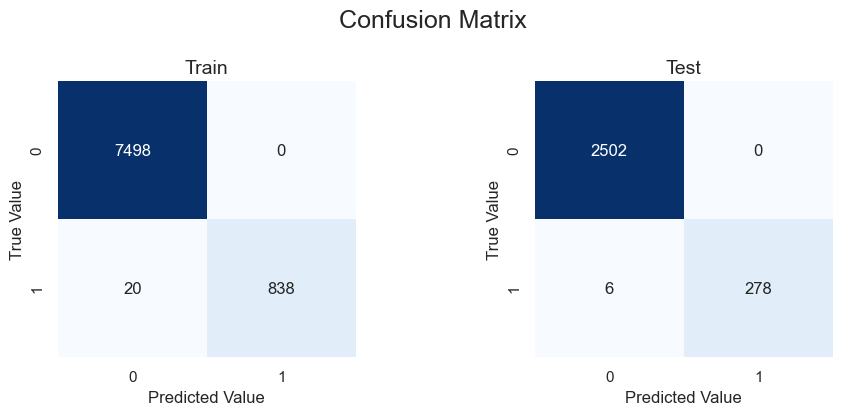

In [778]:
# Plotting th confusion matrix for comparison
plot_cm(y_train,train_predict_rf,y_test,predict_rf)

In [780]:
# Defining the metrics data frame for Random Forest
rf_df = metrics_df(best_model_rf, X_test, y_test, 'Random Forest')
rf_df

,Precision_0,Precision_1,Recall_0,Recall_1,F1-Score_0,F1-Score_1,Accuracy
Random Forest,1.0,1.0,1.0,0.98,1.0,0.99,1.0


##### Inference
* The Training and Test set scored really well with __98% Recall__ and __100% Accuracy__.
* The AUC scores are close to 1. The losses are also very low.
* Since the scores of both are close to each other, The model has performed well and is not overfitting.

### Gradient Boosting

#### Base Model

In [861]:
# Defining the base model
model_gb = GradientBoostingClassifier(random_state=42)

#### Hyper-Parameter Tuning

In [960]:
# Defining the parameters for tuning
# These are the parameters that i worked on. Because of it requires so much computation,
# i tuned the parameters one by one, by taking the following values and some other extreme values.

# param_gb = {
#     'learning_rate' : [0.01, 0.05, 0.1, 1],
#     'n_estimators': [60,80,100,120,140],
#     'max_features' : ['sqrt', 4, 5, 6],
#     'max_depth': [i for i in range(3,10,2)],
#     'min_samples_split': [2,5,10],
#     'min_samples_leaf': [1,2,5,8]
# }

In [961]:
# Best params that i got after hyper tuning
best_params = {
    'learning_rate' : [0.1],
    'n_estimators': [80],
    'max_features' : ['sqrt'],
    'max_depth': [6],
    'min_samples_split': [10],
    'min_samples_leaf': [3]
}

In [962]:
# Performing Grid Search with cv=5 and fitting the dataset
grid_gb = GridSearchCV(model_gb, best_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [6],
                         'max_features': ['sqrt'], 'min_samples_leaf': [3],
                         'min_samples_split': [10], 'n_estimators': [80]},
             scoring='recall', verbose=1)

In [965]:
# Defining the best model variable
best_model_gb = grid_gb.best_estimator_
best_model_gb

GradientBoostingClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                           min_samples_split=10, n_estimators=80,
                           random_state=42)

Best parameters are:<br>
learning_rate = 0.1,<br>
max_depth = 6,<br>
max_features = 'sqrt',<br>
min_samples_leaf = 3,<br>
min_samples_split = 10,<br>
n_estimators = 80,<br>
random_state = 42

#### Model Evaluation

In [966]:
# Predicting the training set and printing the classification report
train_predict_gb = best_model_gb.predict(X_train)
print(metrics.classification_report(y_train,train_predict_gb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7498
           1       1.00      1.00      1.00       858

    accuracy                           1.00      8356
   macro avg       1.00      1.00      1.00      8356
weighted avg       1.00      1.00      1.00      8356



In [967]:
# Predicting the test set and printing the classification report
predict_gb = best_model_gb.predict(X_test)
print(metrics.classification_report(y_test,predict_gb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2502
           1       1.00      0.99      0.99       284

    accuracy                           1.00      2786
   macro avg       1.00      0.99      1.00      2786
weighted avg       1.00      1.00      1.00      2786



In [968]:
# Checking auc scores
print('Train -', metrics.roc_auc_score(y_train,train_predict_gb))
print('Test -', metrics.roc_auc_score(y_test,predict_gb))

Train - 1.0
Test - 0.9929577464788732


In [969]:
train_loss = metrics.log_loss(y_train,train_predict_gb)
test_loss = metrics.log_loss(y_test,predict_gb)
train_loss, test_loss

(2.2204460492503136e-16, 0.05174968182213541)

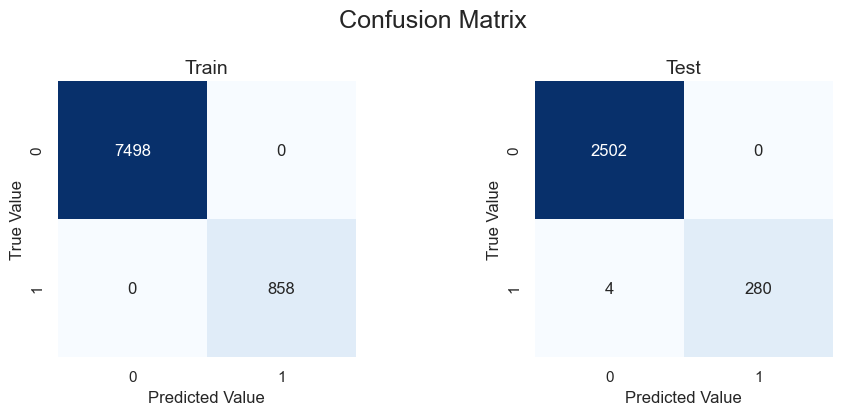

In [970]:
# Plotting the confusion matrix for comparison
plot_cm(y_train, train_predict_gb, y_test, predict_gb)

In [971]:
# Defining the metrics data frame for Gradient Boosting
gb_df = metrics_df(best_model_gb,X_test,y_test,'Gradient Boosting')
gb_df

,Precision_0,Precision_1,Recall_0,Recall_1,F1-Score_0,F1-Score_1,Accuracy
Gradient Boosting,1.0,1.0,1.0,0.99,1.0,0.99,1.0


##### Inference
* The Training set scored perfect.
* The Test also scored near to perfect.
* The Losses of both sets are very low, with a little difference.
* AUC scores were also perfect for train and close to 1.
* Considering the above factors, the model is overfitting.

## Conclusion

In the context of detecting fraudulent activities, our primary objective is to ensure that the model scores highest in recall.<br>
The model should accurately predict the potential fraud cases, because if even one fraud transaction is missed, it can lead to huge loss.<br>
However, while striving for high recall, it is essential to maintain balanced performance to avoid any unnecessary interuption to customers whose transactions are safe.<br>
We will now evaluate and compare the models to choose the one best model for fraud detection

In [972]:
# Concatenate the dataframes
results = pd.concat([lr_df,rf_df,gb_df])

# Sort by 'recall_1'
results = results.sort_values(by='Recall_1', ascending=False)
results

,Precision_0,Precision_1,Recall_0,Recall_1,F1-Score_0,F1-Score_1,Accuracy
Gradient Boosting,1.0,1.0,1.00,0.99,1.00,0.99,1.00
Random Forest,1.0,1.0,1.00,0.98,1.00,0.99,1.00
Logistic Regression,1.0,0.9,0.99,0.97,0.99,0.93,0.99


In [973]:
results['Recall_1']

Gradient Boosting      0.99
Random Forest          0.98
Logistic Regression    0.97
Name: Recall_1, dtype: float64

Text(0, 0.5, 'Models')

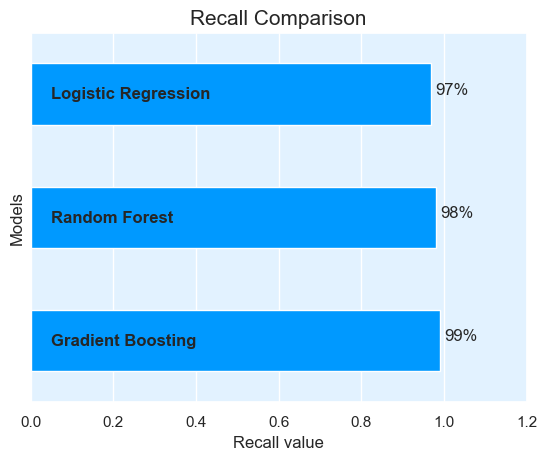

In [974]:
# Plotting the results
recall_plot = results['Recall_1'].plot(kind='barh')

for i, (value,model) in enumerate(zip(results['Recall_1'],results.index)):
    plt.text(value + 0.01,i,str(int(value*100))+'%')
    plt.text(0.05,i,model,va='center',fontweight='bold')

recall_plot.set_yticks([])
plt.xlim(0,1.2)
plt.title('Recall Comparison',fontsize=15)
plt.xlabel('Recall value')
plt.ylabel('Models')

### Inference:
* The __Gradient Boosting__ model scored with the highest recall __0.99__.
* __Random Forest__ also performed well with slighly low recall __0.98__.
* __Logistic Regression__ was not able to perform that well in terms of precision, But scored well with recall as __0.97__
* Overall, if we compare Random Forest and Gradient Boosting, Gradient Boosting did better. But it is overfitting.

### Result:
__Random Forest__ is the perfect model to detect future frauds.

## Financial Losses

Due to some errors in the model, the losses must be calculated to evaluate the model performance.

In [975]:
# Finding the errors in our Random forest Model
best_model_rf.fit(X,y)
y_pred = best_model_rf.predict(X)
y_actual = np.array(y)
print(metrics.classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      0.97      0.98      1142

    accuracy                           1.00     11142
   macro avg       1.00      0.99      0.99     11142
weighted avg       1.00      1.00      1.00     11142



In [976]:
y_comb = pd.DataFrame([y_actual,y_pred],index=['y_actual','y_pred']).T
false_negative = y_comb[(y_comb['y_actual'] == 1) & (y_comb['y_pred'] == 0)]

Loss = 0
for i in false_negative.index:
    Loss += X['amount'][i]
Loss

10334354.600000001

So expected loss is about __Rs. 10,33,4354__, which is about Rs. 20 Lakh (approx.)